In [30]:
%%capture --no-stderr
%pip install -U langchain tavily-python langgraph matplotlib langchain_community langchain-openai scikit-learn langchainhub langchain-ollama langchain-nomic nomic[local]


In [31]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_core.tools import tool

# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Add the document chunks to the "vector store" using NomicEmbeddings
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
    #embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever(k=4)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [32]:
from langchain_ollama import ChatOllama
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

llm = ChatOllama(
    model="llama3.1",
    temperature=0,
)

rag_chain = prompt | llm | StrOutputParser()

In [33]:
rag_chain.invoke(
    {
        "question": "What are the types of agent memory?",
        "documents": retriever.invoke("What are the types of agent memory?"),
    }
)

'There are several types of memory in human brains and LLM-powered autonomous agents. They include sensory memory, short-term memory, long-term memory, and maximum inner product search (MIPS). Sensory memory is the earliest stage of memory, providing the ability to retain impressions of sensory information after the original stimuli have ended.'

In [34]:
from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import StrOutputParser

# Define the modified prompt template
prompt = PromptTemplate(
    template="""You are a grader assessing relevance of retrieved documents to a user question. 

    Here are the retrieved documents:
    {documents}

    Here is the user question: {question}

    For each document, if it contains keywords related to the user question, grade it as relevant. 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. 

    Provide a binary score 'yes' or 'no' for each document to indicate whether the document is relevant to the question. 
    Provide the scores as a JSON list with keys 'doc1', 'doc2', 'doc3', and 'doc4', corresponding to each document.

    Scores: 
    {{
        "doc1": "yes/no",
        "doc2": "yes/no",
        "doc3": "yes/no",
        "doc4": "yes/no"
    }}
    """,
    input_variables=["question", "documents"],
)

llm = ChatOllama(
    model="llama3.1",
    temperature=0,
    #url='https://7329-34-16-208-221.ngrok-free.app',

)

# Define a function to generate the input text with multiple documents
def format_documents(doc_list):
    formatted_docs = ""
    for i, doc in enumerate(doc_list, start=1):
        formatted_docs += f"Document {i}: {doc}\n\n"
    return formatted_docs

# Example usage with a list of documents
documents = retriever.invoke("What are the types of agent memory?")  # Assuming retriever is defined
formatted_documents = format_documents(documents)

# Prepare the input for the prompt
input_data = {
    "question": "What are the types of agent memory?",
    "documents": formatted_documents
}

# Create the RAG chain
ret_chain = prompt | llm | StrOutputParser()

# Invoke the RAG chain
response = ret_chain.invoke(input_data)
print(response)


Here are the scores:

{
  "doc1": "no",
  "doc2": "yes",
  "doc3": "yes",
  "doc4": "yes"
}

Explanation:

* Document 1: The document mentions "Memory" in the context of a comparison between different algorithms, but it does not explicitly discuss types of agent memory. Score: no
* Document 2: This document discusses Generative Agents and mentions "memory stream", which is a type of long-term memory module. Score: yes
* Document 3: The document has a section on "Component Two: Memory" and lists different types of memory, including Maximum Inner Product Search (MIPS). Score: yes
* Document 4: This document explicitly discusses the types of agent memory, including sensory memory, short-term memory, and long-term memory. Score: yes


In [35]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

# JSON
llm = ChatOllama(model="llama3.1", 
                 format="json", 
                 temperature=0)


prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()

In [36]:
retrieval_grader.invoke(
    {
        "question": "What are the types of agent memory?",
        "document": retriever.invoke("What are the types of agent memory?"),
    }
) 

{'score': 'yes'}

In [68]:
from langchain_core.messages import (
    BaseMessage,
)
import operator
from typing import Annotated, List,TypedDict


class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]

In [69]:
def retrieve(state:State):
    print("documents relevant to your question are being retrieved ")
    question=state["question"]
    documents =retriever.invoke(question)
    steps=state['steps']
    steps.append("retrieve_docs")
    
    return { "documents" : documents ,
              "question" : question , 
              "steps" : steps,
    }

In [70]:
def grade_documents(state:State):
    documents=state['documents']
    question=state['question']
    steps=state['steps']
    steps.append("grading_retrieved_docs")
    filtred_docs = []
    search = "No"
    for doc in documents:
        score = retrieval_grader.invoke({"question":question , "document":doc.page_content}) 
        grade =score['score']
        if grade == "yes" :
            filtred_docs.append(doc)
        else:
            search="Yes"
            continue
    return { "documents" : filtred_docs ,
              "question" : question , 
              "search" : search,
              "steps" : steps ,
    }



In [56]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

In [41]:
search.run("Obama's first name?")

"Barack Obama—with his wife, Michelle—being sworn in as the 44th president of the United States, January 20, 2009. Key events in the life of Barack Obama. Barack Obama (born August 4, 1961, Honolulu, Hawaii, U.S.) is the 44th president of the United States (2009-17) and the first African American to hold the office. Barack Hussein Obama II (/ b ə ˈ r ɑː k h uː ˈ s eɪ n oʊ ˈ b ɑː m ə / (); born August 4, 1961) is an American politician and attorney. He was the 44th president of the United States from 2009 to 2017. He was the first African-American president in U.S. history. A member of the Democratic Party, he also served as member of the Illinois Senate from 1997 to 2004 and a United States ... As the head of the government of the United States, the president is arguably the most powerful government official in the world. The president is elected to a four-year term via an electoral college system. Since the Twenty-second Amendment was adopted in 1951, the American presidency has been 

In [71]:
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchResults



wrapper = DuckDuckGoSearchAPIWrapper( max_results=2)

search = DuckDuckGoSearchResults(api_wrapper=wrapper, source="news")

In [43]:
search.run("Obama's first name?")

'[snippet: Barack Obama—with his wife, Michelle—being sworn in as the 44th president of the United States, January 20, 2009. Key events in the life of Barack Obama. Barack Obama (born August 4, 1961, Honolulu, Hawaii, U.S.) is the 44th president of the United States (2009-17) and the first African American to hold the office., title: Barack Obama | Biography, Parents, Education, Presidency, Books ..., link: https://www.britannica.com/biography/Barack-Obama], [snippet: Barack Hussein Obama II (/ b ə ˈ r ɑː k h uː ˈ s eɪ n oʊ ˈ b ɑː m ə / (); born August 4, 1961) is an American politician and attorney. He was the 44th president of the United States from 2009 to 2017. He was the first African-American president in U.S. history. A member of the Democratic Party, he also served as member of the Illinois Senate from 1997 to 2004 and a United States ..., title: Barack Obama - Simple English Wikipedia, the free encyclopedia, link: https://simple.wikipedia.org/wiki/Barack_Obama], [snippet: Jame

In [72]:
import pprint

from langchain_community.utilities import SearxSearchWrapper

searchX = SearxSearchWrapper(searx_host="http://localhost:8080" , k=3)

In [45]:
searchX.run("Obama's first name?",engines=["wiki"])

"Why did Obama make the conscious decision to take on his formal African name? His father was also Barack, and also Barry: he chose the nickname when he came to America from Kenya on a scholarship ...\n\nBarack Obama's parents met in 1960 while they were students at the University of Hawaii at Manoa.Obama's father, Barack Obama, Sr., the university's first foreign student from an African nation, hailed from Oriang' Kogelo, Rachuonyo North District, in the Nyanza Province of western Kenya. Obama's mother, Stanley Ann Dunham, known as Ann, had been born in Wichita.\n\nBarack Obama was the 44 th president of the United States and the first Black commander-in-chief. He served two terms, from 2009 until 2017. He served two terms, from 2009 until 2017."

In [73]:
import json
from langchain_core.documents import Document  # Ensure this is the correct import


def web_search(state:State):
    question = state['question']
    steps = [state['steps']]
    steps.append("web_search")
    result=searchX.run(question)
    documents = state["documents"]
    documents.append(
        Document(page_content=result, metadata={"source": "SearX"})
    )
    return {"documents": documents, "question": question, "steps": steps}
    

In [47]:
state ={
    "question" : "hello world", 
    "documents" : [],
    "steps":[]
}

In [48]:
web_search(state)

{'documents': [Document(metadata={'source': 'SearX'}, page_content='A "Hello, World!"program is generally a simple computer program which outputs (or displays) to the screen (often the console) a message similar to "Hello, World!"while ignoring any user input. A small piece of code in most general-purpose programming languages, this program is used to illustrate a language\'s basic syntax.A "Hello, World!" program is often the first written by a student of a ...\n\nHello World! In Computer Science 101, the first program many students create is a simple one that outputs an iconic line of text: "Hello World!" Say hello to the world of computer science with this introductory activity that equips students with the basic coding skills and confidence to create apps. Choose from six fun themes to code ...\n\nHello, World! Python is a very simple language, and has a very straightforward syntax. It encourages programmers to program without boilerplate (prepared) code. The simplest directive in 

In [74]:
def generate(state:State):
    question= state['question']
    documents = state['documents']
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state['steps']
    steps.append("generate_response")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


In [50]:
generate(state)

{'documents': [Document(metadata={'source': 'SearX'}, page_content='A "Hello, World!"program is generally a simple computer program which outputs (or displays) to the screen (often the console) a message similar to "Hello, World!"while ignoring any user input. A small piece of code in most general-purpose programming languages, this program is used to illustrate a language\'s basic syntax.A "Hello, World!" program is often the first written by a student of a ...\n\nHello World! In Computer Science 101, the first program many students create is a simple one that outputs an iconic line of text: "Hello World!" Say hello to the world of computer science with this introductory activity that equips students with the basic coding skills and confidence to create apps. Choose from six fun themes to code ...\n\nHello, World! Python is a very simple language, and has a very straightforward syntax. It encourages programmers to program without boilerplate (prepared) code. The simplest directive in 

In [75]:
def decide_to_generate(state:State): 
    search = state['search']
    if search == "Yes" : 
        return "web_search"
    else : 
        return "generate"

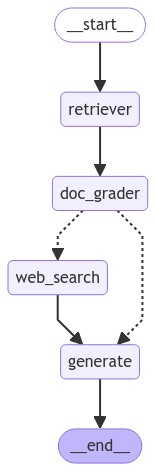

In [76]:
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display

workflow = StateGraph(State)

workflow.add_node("retriever" , retrieve)
workflow.add_node("doc_grader" , grade_documents)
workflow.add_node("web_search" , web_search)
workflow.add_node("generate" , generate)

workflow.set_entry_point("retriever")
workflow.add_edge("retriever" , "doc_grader")
workflow.add_conditional_edges("doc_grader",
                               decide_to_generate,
                               {"web_search" :"web_search", "generate" : "generate"})

workflow.add_edge("web_search", "generate")
workflow.add_edge("generate" , END)



custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))


In [79]:
from dotenv import load_dotenv
import os

load_dotenv()


True

In [80]:
from langfuse.callback import CallbackHandler
langfuse_handler = CallbackHandler(
    public_key=os.getenv('LANGFUSE_PUBLIC_KEY'),
    secret_key=os.getenv('LANGFUSE_SECRET_KEY'),
    host=os.getenv('LANGFUSE_HOST'),
)

In [81]:
initial_state = {
    "question": "Hello world",
    "steps": [],
    "documents":[]
}

custom_graph.invoke(initial_state , config={"callbacks":[langfuse_handler]})

documents relevant to your question are being retrieved 


{'question': 'Hello world',
 'generation': 'A "Hello, World!" program is a simple computer program that outputs the message "Hello, World!" to the screen. This type of program is often used in introductory programming courses to teach basic coding skills. It typically ignores any user input and is designed to be easy to understand and implement.',
 'search': 'Yes',
 'documents': [Document(metadata={'source': 'SearX'}, page_content='1 week ago - A "Hello, World!" program is generally a simple computer program which outputs (or displays) to the screen (often the console) a message similar to "Hello, World!" while ignoring any user input. A small piece of code in most general-purpose programming languages, this program is used to illustrate ...\n\nHello World! In Computer Science 101, the first program many students create is a simple one that outputs an iconic line of text: "Hello World!" Say hello to the world of computer science with this introductory activity that equips students with